# Projektpraktikum Data Mining Cup - CatBoost
## Feature Engineering, Hyperparameter-Tuning und Anwendung des Models
#### Dominik Lewin, Mario Teßmann, Johannes Winkler

Nach dem Trainieren diverser Algorithmen stellte sich heraus, dass Boosting Algorithmen die besten Ergebnisse erzielen, darunter XGBoost, LightGBM und CatBoost. Dabei konnte der Algorithmus CatBoost die besten Ergebnisse erzielen. Aus diesem Grund wurden alle anderen Modelle verworfen. In diesem Jupyter Notebook wird es darum gehen, das Modell zu optimieren, indem weitere Attribute hinzugefügt bzw. nicht benötigte Attribute entfernt werden. Dafür wird der während der vorausgehenden Phase entwickelte aufbereitete Datensatz verwendet. 

Anschließend sollen die Hyperparameter optimiert werden, um zuletzt das fertig trainierte Model auf den Testdaten aus 2019 anzuwenden.


# Inhaltsverzeichnis

* [1. Verwendete Funktionen](#funktionen)
* [2. CatBoost auf dem aufbereiteten Datensatz](#aufbereitet)
* [3. Verwerfen von most_frequent-product](#most)
* [4. Erzeugen eines Cash-Flags und sinnvoller Quotienten](#quot)
* [5. Verwerfen von n_items, void_per_time und line_voids](#void)
* [6. Kundendichte](#dichte)
* [7. Besonders gefährdete Zeiten](#zeiten)
* [8. Durchschnittlicher Preis und Zeit pro Artikel](#preis)
* [9. Tag und Monat](#tag)
* [10. Weihnachts- und Osterzeit](#weihnachten)
* [11. Fazit des Feature Engineerings](#fazit)
* [12. Hyperparameter Tuning](#fazit)
* [13. Umgang mit unbalancierten Daten](#fazit)
* [14. Vorhersage der Testdaten für 2019](#abgabe)



## 1. Verwendete Funktionen <a class="anchor" id="funktionen"></a>

Um das Trainieren der Modelle und die Ausgabe vergleichbarer Ergebnisse zu vereinfachen, werden einige Funktionen erstellt. Diese erstellen auf dem jeweiligen Datensatz immer einen reproduzierbaren Trainings- und Testdatensatz, trainiert anschließend das Modell auf den Trainingsdaten und gibt schließlich umfangreiche Ergebnisse des Testdatensatzes aus. Dazu gehören:
- Ergebnisse der Kreuzvalidierung
- Die Konfusionsmatrix
- Der Gewinn bzw. Verlust nach vorgegebener Kostenfunktion
- Feature Importances

Die verwendete Kostenfunktion wurde von der Auftraggeberin vorgegeben und enthält folgende Bedingungen:
- Für korrekt erkannte fehlerhafte Einkäufe (true-positive): +5 Euro
- Für nicht erkannte fehlerhafte Einkäufe (false-negative): -5 Euro
- Für korrekte Einkäufe, die als fehlerhaft klassifiziert werden (false-positive): -25 Euro

Somit lautet die Gewinnfunktion:

>$Gewinn = TP * 5 - FP * 25 - FN * 5$


In [1]:
#Pakete importieren
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer
from datetime import timedelta
from sklearn.model_selection import GridSearchCV

In [2]:
#Globale Variablen
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [3]:
# Eigene Gewinnfunktion für Kreuzvalidierung definieren
def score_function(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    tp = conf_matrix[1, 1]
    fp = conf_matrix[0, 1]
    fn = conf_matrix[1, 0]
    score = tp * 5 - fp * 25 - fn * 5
    return score

# Scorer erstellen
custom_scorer = make_scorer(score_function, greater_is_better=True)

In [4]:
#Datensatz zufällig in Trainings- und Testdaten splitten
def get_train_test(df):
    X = df.drop(["label"], axis=1)
    y = df["label"]
    
    #Erzeuge Trainings- und Testdaten
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    return X_train, X_test, y_train, y_test

In [5]:
#Ergebnisse des Modells ausgeben
def result(model, X_test, y_test):
    # Vorhersagen für Testdaten machen
    y_pred = model.predict(X_test)

    # Konfusionsmatrix erstellen
    conf_matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)
    score = conf_matrix[1,1]*5 - conf_matrix[0,1]*25 - conf_matrix[1,0]*5
    print()
    print("Gewinn: ", score)
    
    print()
    print("Konfusionsmatrix:")
    print(conf_matrix)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=model.classes_)
    disp.plot()
    plt.show()

In [6]:
def importances(X, model):
    # Feature Importances erhalten
    feature_importances = model.get_feature_importance()

    # Feature-Namen aus dem DataFrame
    feature_names = X.columns

    # Feature Importances mit Feature-Namen zusammenführen und sortieren
    sorted_importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)
        
    # Sortieren der Feature Importances für bessere Lesbarkeit
    features, importances = zip(*sorted_importances)

    # Plotten der Feature Importances mit Werten
    plt.figure(figsize=(10, 6))
    plt.barh(features, importances)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importances in CatBoost Classifier')

    # Importance-Werte direkt im Graphen anzeigen
    for index, value in enumerate(importances):
        plt.text(value, index, f'{value:.2f}')

    plt.gca().invert_yaxis()
    plt.show()

In [7]:
def train_test(df, model):
    #Daten splitten
    X_train, X_test, y_train, y_test = get_train_test(df)
    
    #Model trainieren
    model.fit(X_train, y_train)
    
    #Kreuzvalidierung durchführen
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=custom_scorer)
    
    #Ergebnisse ausgeben
    print("Ergebnisse der Kreuzvalidierung:")
    print()
    print("Erreichte Gewinne: ", scores)
    print("Erreichter mittlerer Gewinn ", scores.mean())
    print("Standardabweichung: ", scores.std())
    result(model, X_test, y_test)
    importances(X_train, model)

In [8]:
#Die Funktion bekommt das trainierte Modell, eine Liste von Dictionaries, den Trainingsdatensatz
#ohne Labels und die Trainingslabels übergeben.
#Es werden alle Kombinationen probehalber je 5 mal trainiert, um die beste Kombination von Hyperparametern
#zu erhalten. Die Ergebnisse für jede Kombination wird ausgegeben. Die beste Kombination wird ausgegeben.

def gittersuche(model, param_grid, X_train, y_train, methode=custom_scorer):
    
    grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring=methode,return_train_score=True)
    #Trainiere auf Trainingsdaten
    grid_search.fit(X_train, y_train)
     
    #Gebe die beste Kombination der Hyperparameter aus
    print()
    print("Beste Parameter: ", grid_search.best_params_)
    print("Bester Score: ", grid_search.best_score_)
    return

## 2. CatBoost auf dem aufbereiteten Datensatz <a class="anchor" id="aufbereitet"></a>

Hierfür werden zunächst die Daten eingelesen.

In [9]:
#Einlesen des aufbereiteten Datensatzes aus der vorherigen Phase
df = pd.read_csv("final_df_train.csv", sep=",", index_col=0)

In [10]:
params = {
    'objective': 'Logloss',
    'random_state': RANDOM_STATE,
    "loss_function": "AUC",
    'verbose':False
}

Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [-1155  -800  -925 -1015 -1145]
Erreichter mittlerer Gewinn  -1008.0
Standardabweichung:  134.59569086712992

Gewinn:  -1360

Konfusionsmatrix:
[[20004    18]
 [  545   363]]


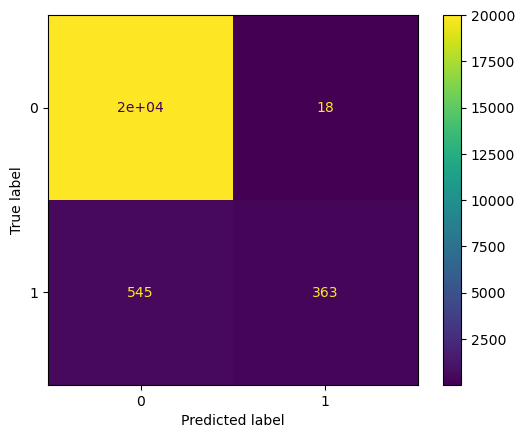

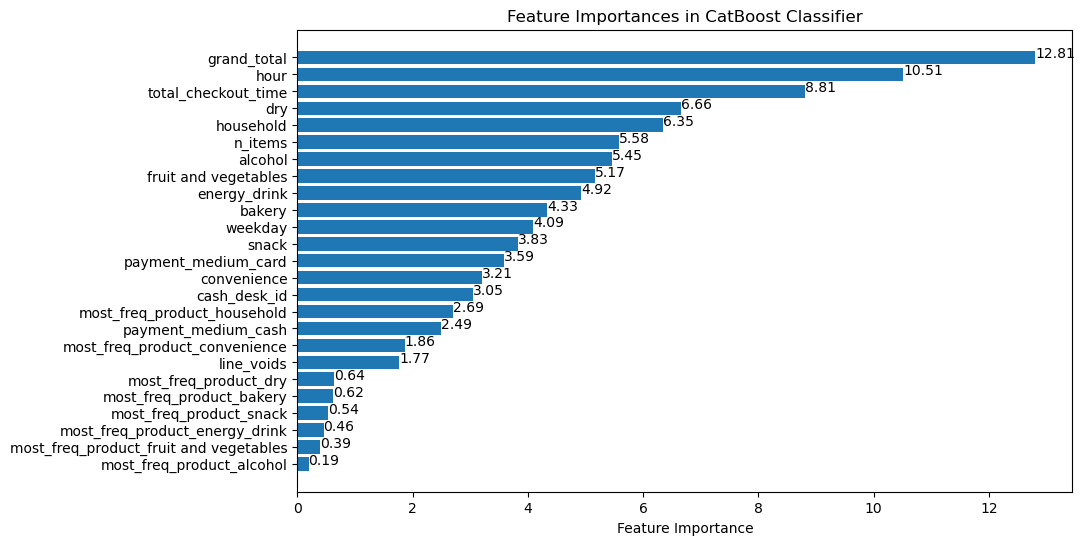

In [11]:
model = CatBoostClassifier(**params,)
train_test(df, model)

## 3. Verwerfen von most_frequent-product <a class="anchor" id="most"></a>

Wie man soeben gesehen hat, hat das most_frequent_product einen sehr geringen Einfluss auf die Klassifikation des Modells. Dies wird vermutlich daran liegen, dass dem Algorithmus die Anzahl der einzelnen Produkte bekannt ist und somit auch auf das am meisten enthaltene Produkt geschlossen werden kann. Die Information ist somit bereits indirekt in den Daten enthalten. Aus diesem Grund werden diese Attribute entfernt. Auch das Attribut cash_desk_id wird an dieser Stelle verworfen, da es wenig relevant ist.

Das Attribut line_voids hat zwar auch einen geringen Einfluss, wird aber im weiteren Verlauf noch optimiert und bleibt daher zunächst bestehen. 

In [12]:
df = df.drop(['most_freq_product_alcohol', 'most_freq_product_bakery',
       'most_freq_product_convenience', 'most_freq_product_dry',
       'most_freq_product_energy_drink',
       'most_freq_product_fruit and vegetables', 'most_freq_product_household',
       'most_freq_product_snack', 'cash_desk_id'], axis=1)

Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [-1285  -880  -970 -1105 -1030]
Erreichter mittlerer Gewinn  -1054.0
Standardabweichung:  137.01824696003084

Gewinn:  -1420

Konfusionsmatrix:
[[20002    20]
 [  546   362]]


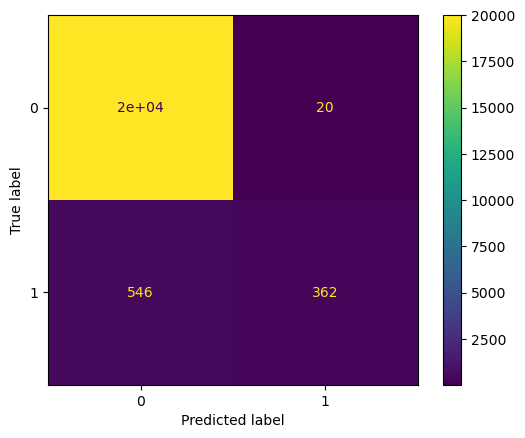

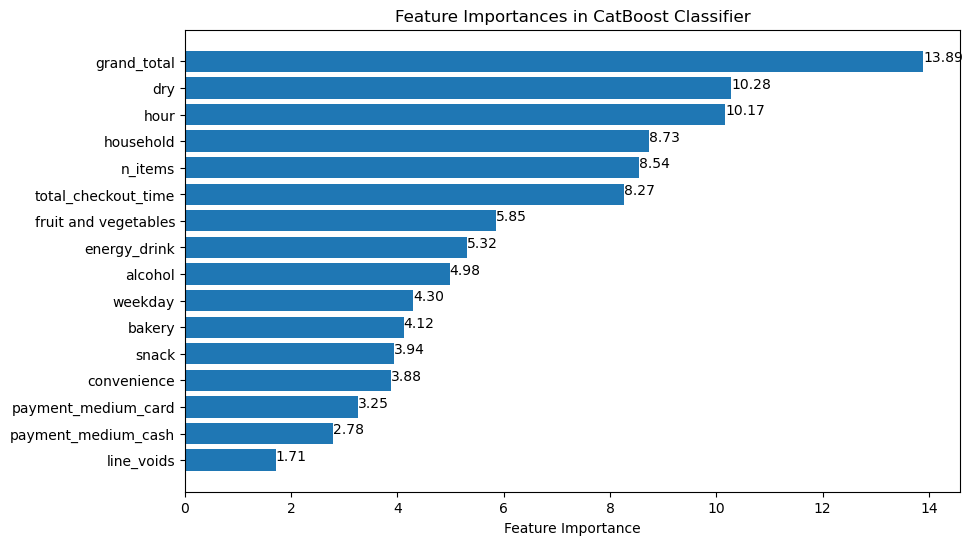

In [13]:
model = CatBoostClassifier(**params,)
train_test(df, model)

Es ist zu erkennen, dass das Modell zwar nicht besser wird, aber auch ohne das most_frequent_product funktioniert das Modell genauso gut.

## 4. Erzeugen eines Cash-Flags und sinnvoller Quotienten <a class="anchor" id="quot"></a>

Da die Einführung der Bargeldzahlungen erst zu einem späteren Zeitpunkt erfolgte, kann es sinnvoll sein, ein weiteres Attribut zu erzeugen, das angibt, ob eine Bargeldzahlung möglich war (1) oder nicht (0).

Zudem wurden in der vorherigen Phase vielversprechende Quotienten gefunden, die an dieser Stelle hinzugefügt werden.

In [14]:
#Hinzufügen eines Attributs, das angibt, dass eine Bargeldzahlung möglich war
idx_cash_epoch = (df.payment_medium_cash == 1).idxmax()
df["cash_epoch"] = 0
df.loc[idx_cash_epoch:, "cash_epoch"] = 1

In [15]:
#Hinzufügen weiterer sinnvoller Attribute
df["item_per_time"] = df["n_items"] / df["total_checkout_time"]
df["item_per_EUR"] = df["n_items"] / df["grand_total"]
df["void_per_time"] = df["line_voids"] / df["n_items"]

df.head()

,grand_total,n_items,total_checkout_time,line_voids,alcohol,fruit and vegetables,snack,dry,convenience,bakery,...,energy_drink,weekday,hour,payment_medium_card,payment_medium_cash,label,cash_epoch,item_per_time,item_per_EUR,void_per_time
0,63.31,24,324,1,1,5,1,11,3,3,...,0,0,8,1,0,0,0,0.074074,0.379087,0.041667
1,29.59,11,92,0,1,2,3,5,0,0,...,0,0,8,1,0,0,0,0.119565,0.371747,0.000000
2,28.70,12,160,0,1,2,1,4,0,4,...,0,0,8,1,0,0,0,0.075000,0.418118,0.000000
3,37.95,8,120,0,0,1,1,3,1,1,...,0,0,8,1,0,0,0,0.066667,0.210804,0.000000
4,5.26,4,79,2,0,1,0,2,0,1,...,0,0,8,1,0,0,0,0.050633,0.760456,0.500000


Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [ -960  -800  -835  -805 -1005]
Erreichter mittlerer Gewinn  -881.0
Standardabweichung:  84.9352694703443

Gewinn:  -1140

Konfusionsmatrix:
[[20004    18]
 [  523   385]]


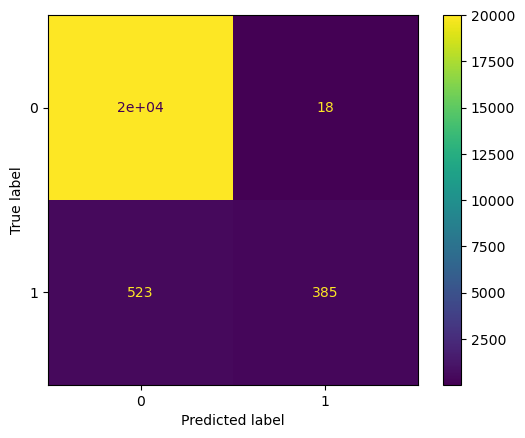

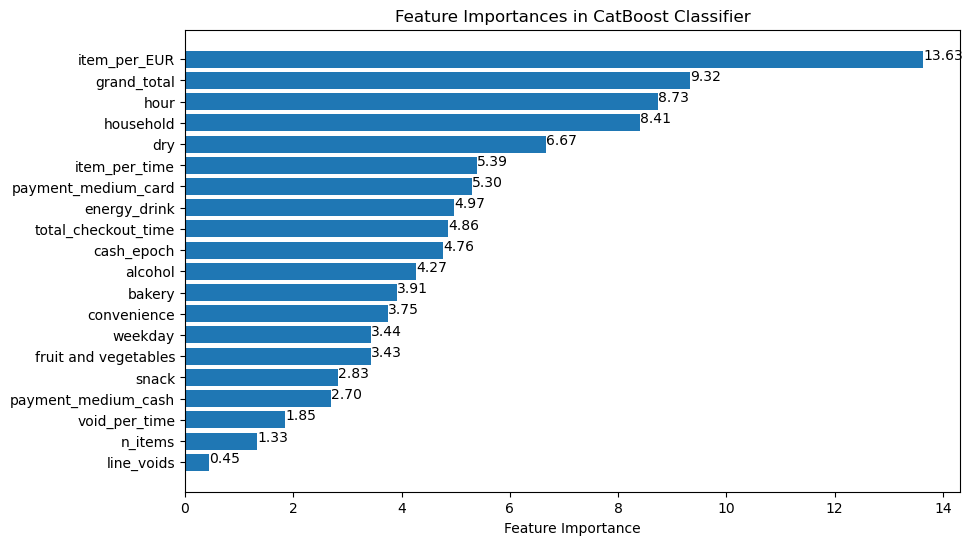

In [16]:
model = CatBoostClassifier(**params,)
train_test(df, model)

Offensichtlich haben drei der neu hinzugefügten Attribute etwas zur Verbesserung des Modells beigetragen. Der Gewinn fällt auf den Testsaten höher aus.

## 5. Verwerfen von n_items, void_per_time und line_voids <a class="anchor" id="void"></a>

An dieser Stelle soll getestet werden, ob das Entfernen der drei schlechtesn Attribute zu einer Verschlechterung des Modells führt oder ob es gleich bleibt. 

In [17]:
df_test = df.drop(["n_items", "void_per_time", "line_voids"], axis=1)

Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [-1150  -675  -740  -865 -1020]
Erreichter mittlerer Gewinn  -890.0
Standardabweichung:  175.41379649275024

Gewinn:  -1115

Konfusionsmatrix:
[[20005    17]
 [  523   385]]


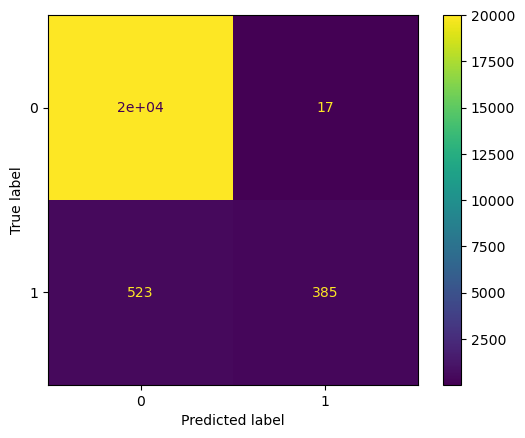

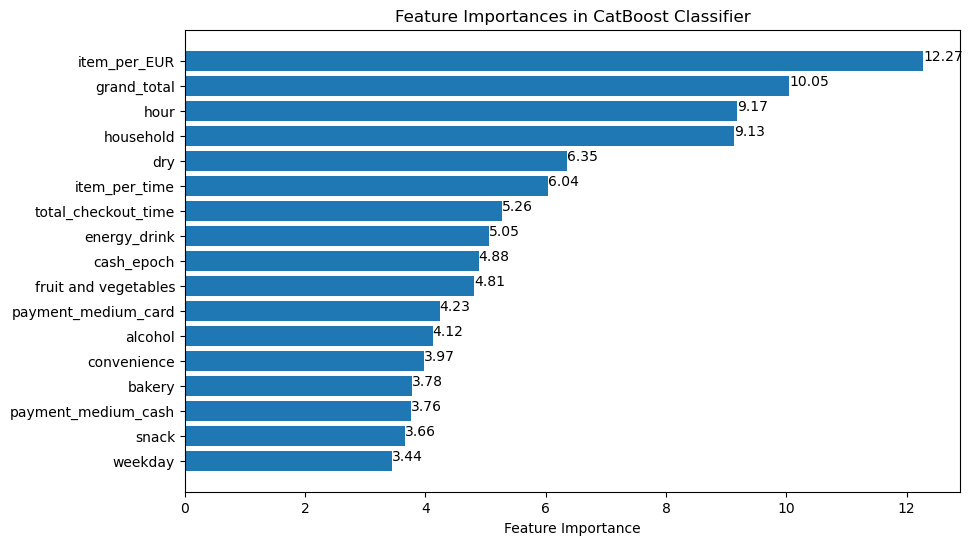

In [18]:
model = CatBoostClassifier(**params,)
train_test(df_test, model)

Tatsächlich wird das Modell durch das Entfernen der drei Attribute schlechter. Auf den Testdaten wirkt es zunächst besser, allerdings steigt der Mittelwert der Kreuzvalidierung an und insbesondere ist die Standardabweichung stark angestiegen, was auf stark variierende Ergebnisse schließen lässt. Daher bleiben die drei Attribute im Datensatz enthalten. Auch das einzelne Entfernen dieser Attribute brachte keine Verbesserung.

## 6. Kundendichte <a class="anchor" id="dichte"></a>

Denkbar ist auch ein Einfluss der Kundendichte im Kassenbereich auf die Klassifikation. Hier sind zwei Szenarien möglich:
- Kunden betrügen eher, wenn sie allein im Kassenbereich sind und sich unbeobachtet fühlen
- Kunden betrügen eher, wenn der Kassenbereich voll ist, da dies in der Masse nicht auffällt

An dieser Stelle soll geprüft werden, ob die aktuelle Kundendichte während der Dauer eines Einkaufs zur Optimierung des Modells beiträgt. Hierfür muss zunächst der originale Datensatz verwendet werden, um den Timestamp zur weiteren Berechnung zu erhalten. Eine genaue Berechnung ist allerdings nicht möglich, da zeitgleich Daten aus drei Geschäften vorliegen. Aus diesem Grund wird der Durschnitt der Kundendichte aller drei Filialen verwendet.

In [19]:
#Funktion gibt an, wie viele Kunden gleichzeitig während des Scanvorgangs im Kassenbereich waren
#es wird ausgenutzt, dass der Datensatz zeitlich sortiert ist
def bestimme_dichte(df, index):
    #Nehme timestamp und bestimme Start- und Endzeit
    start = pd.Timestamp(df.iloc[index].timestamp)
    dauer = df.iloc[index].total_checkout_time
    ende = start + timedelta(seconds=dauer)
    
    #Betrachte Kunden, die nach dem Scanvorgang kommen
    beenden = 0
    i = index+1
    count = 0
    
    while beenden == 0:
        #Nehme timestamp der nächsten Zeile, wenn sie existiert
        if i == len(df):
            beenden = 1
        else:
            naechster = df.iloc[i].timestamp
            if pd.Timestamp(naechster) < pd.Timestamp(ende):
                #Erhöhe den Zähler, denn ein Kunde war zeitlich an der Kasse
                count = count+1
            #Ansonsten kein Kunde mehr zeitgleich an der Kasse, Schleife beenden
            else:
                beenden = 1
        i = i+1
    
    #Betrachte Kunden, die bereits vor dem Scanvorgang im Kassenbereich waren
    beenden = 0
    i = index-1
    
    while beenden == 0:
        #Nehme timestamp der vorherigen Zeile, wenn sie existiert
        if i < 1:
            beenden = 1
        else:
            vorheriger = df.iloc[i].timestamp
            vorh_dauer = df.iloc[i].total_checkout_time
            vorh_ende = pd.Timestamp(vorheriger)+timedelta(seconds=vorh_dauer)
            if vorh_ende > pd.Timestamp(start):
                #Erhöhe den Zähler, denn ein Kunde war zeitlich an der Kasse
                count = count+1
            #Ansonsten kein Kunde mehr zeitgleich an der Kasse, Schleife beenden
            else:
                beenden = 1
        i = i-1
    
    return count/3

In [20]:
#Einlesen des originalen Datensatzes aus der vorherigen Phase
df_original = pd.read_csv("train.csv", sep=",")

In [21]:
#neue Spalte im aufbereiteten Datensatz erzeugen. Es wird ausgenutzt, dass beide Datensätze dieselbe Sortierung
#aufweisen und eine Indexierung der Einträge bzw. ein Join nicht gebraucht wird.
df["customers"] = np.nan

for i in range(len(df_original)):
    weitere_kunden = bestimme_dichte(df_original, i)
    df.at[i, "customers"] = weitere_kunden

Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [-1110  -700  -830  -895  -965]
Erreichter mittlerer Gewinn  -900.0
Standardabweichung:  136.56500283747664

Gewinn:  -1355

Konfusionsmatrix:
[[19997    25]
 [  527   381]]


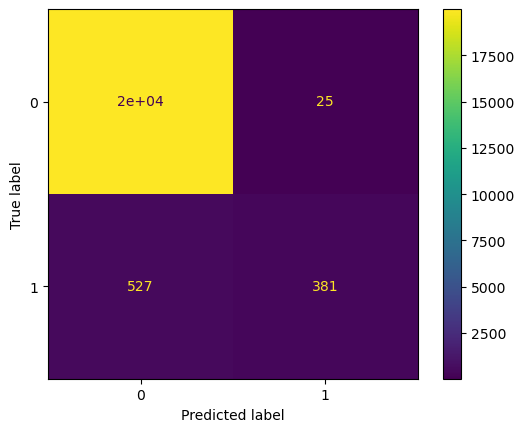

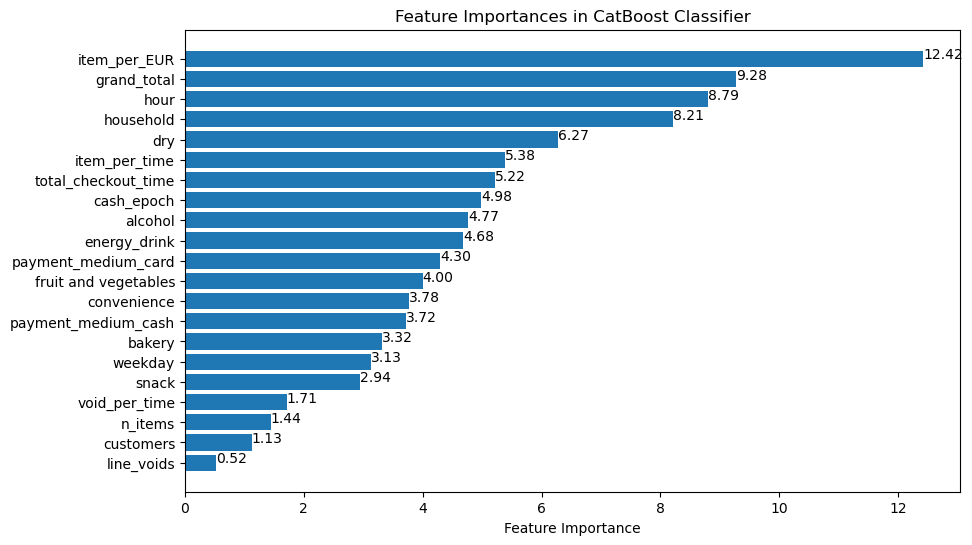

In [22]:
model = CatBoostClassifier(**params,)
train_test(df, model)

Das Attribut trägt leider nicht zu einer Verbesserung bei. Zudem ist der Graphik zu entnehmen, dass das neue Attribut eines der Unwichtigsten ist. Auch in der praktischen Umsetzung wäre es schwierig, dieses Attribut aus den Daten zu extrahieren. Aus diesem Grund wird das Attribut an dieser Stelle wieder verworfen.

In [23]:
df = df.drop(["customers"], axis=1)

## 7. Besonders gefährdete Zeiten <a class="anchor" id="zeiten"></a>

Während der explorativen Datenanalyse wurde herausgefunden, dass an Freitagen und Samstagen besonders viele fraud-Fälle vorhanden sind. Ebenso häufen sich die Fälle durchschnittlich in der Zeit von 16 bis 18 Uhr. Aus diesem Grund soll getestet werden, ob es sinnvoll ist, das Vorhandensein einer der beiden Merkmale im Datensatz als neues Attribut anzugeben.

In [24]:
# Bedingung für die neue Spalte: Freitage, Samstage und Zeiten von 16 bis 18 Uhr erhalten eine 1, sonst 0
condition = (df["weekday"] > 3) | (df["hour"].isin([16, 17, 18]))

# Neue Spalte hinzufügen
df["attention"] = condition.astype(int)

Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [-1045  -700  -915  -835 -1035]
Erreichter mittlerer Gewinn  -906.0
Standardabweichung:  129.24395537122808

Gewinn:  -1150

Konfusionsmatrix:
[[20006    16]
 [  529   379]]


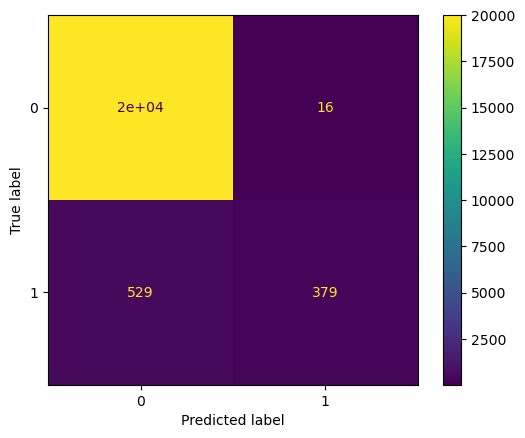

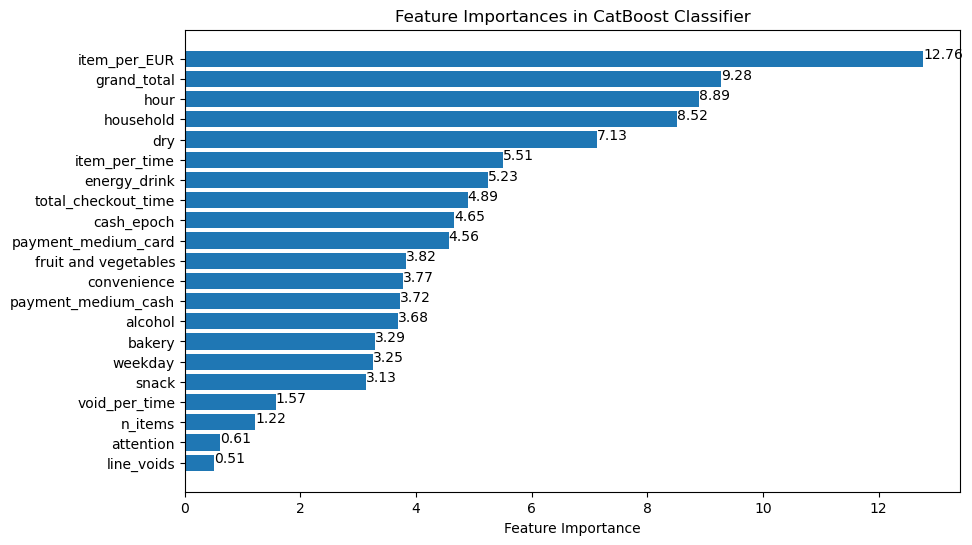

In [25]:
model = CatBoostClassifier(**params,)
train_test(df, model)

Dies führt zu keiner Verbesserung des Modells, weshalb das Attribut wieder verworfen wird.

In [26]:
df = df.drop(["attention"], axis=1)

## 8. Durchschnittlicher Preis und Zeit pro Artikel <a class="anchor" id="preis"></a>

Es könnte sein, dass Kunden, die ihre Artikel sehr schnell scannen (also eine geringe Zeit pro Artikel aufweisen) ein höheres Risiko haben, einen Artikel nicht zu scannen. 
Ein durchschnittlich hoher Preis pro Artikel könnte auf Betrugsversuche hinweisen. Beides wird an dieser Stelle getestet.

In [27]:
df["price_per_product"] = df["grand_total"] / df_original["n_items"]
df["time_per_product"] = df["total_checkout_time"] / df_original["n_items"]

Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [-1055  -695  -785  -945  -940]
Erreichter mittlerer Gewinn  -884.0
Standardabweichung:  127.7654100294755

Gewinn:  -1145

Konfusionsmatrix:
[[20003    19]
 [  521   387]]


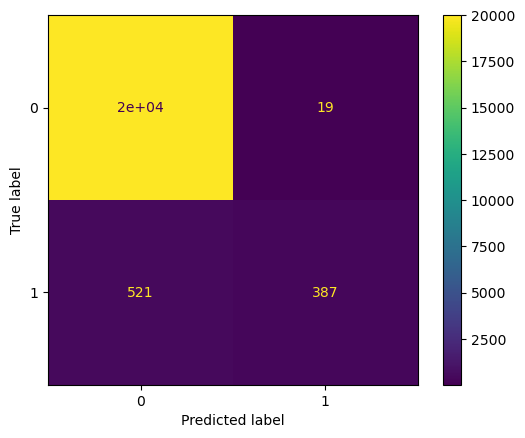

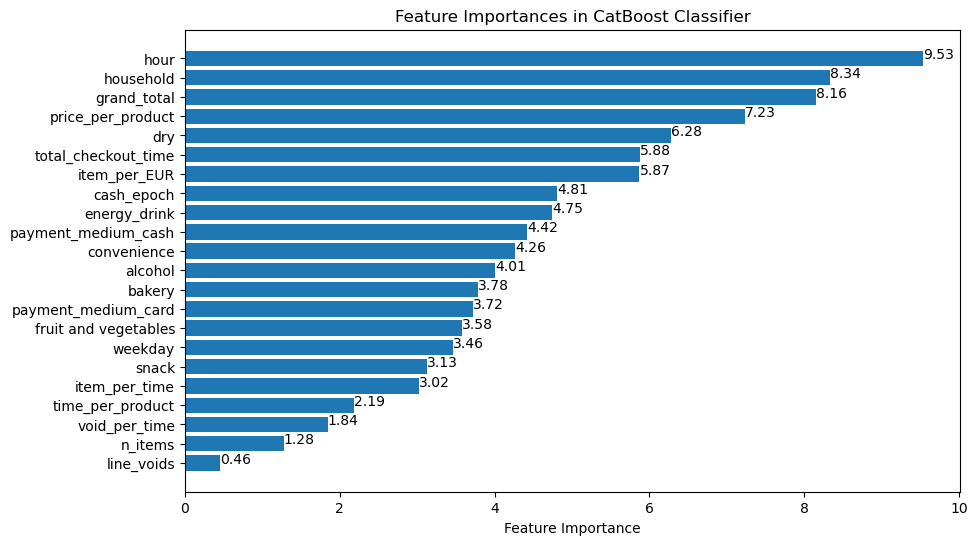

In [28]:
model = CatBoostClassifier(**params,)
train_test(df, model)

Auch hier gibt es leider keine Verbesserung, weshalb beide Attribute verworfen werden.

In [29]:
df = df.drop(["time_per_product", "price_per_product"], axis=1)

## 9. Tag und Monat <a class="anchor" id="tag"></a>

Der Tag des Monats und der Monat wurden im Rahmen der Datenaufbereitung bereits entfernt, da dies als irrelevant eingeschätzt wurde. Dies soll an dieser Stelle noch verifiziert werden. Ggf. kann das Modell diese Attribute doch gebrauchen. 

In [30]:
df['day'] = pd.to_datetime(df_original['timestamp']).dt.day
df['month'] = pd.to_datetime(df_original['timestamp']).dt.month

Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [-1035  -650  -825  -870  -940]
Erreichter mittlerer Gewinn  -864.0
Standardabweichung:  128.35108102388543

Gewinn:  -1205

Konfusionsmatrix:
[[20003    19]
 [  527   381]]


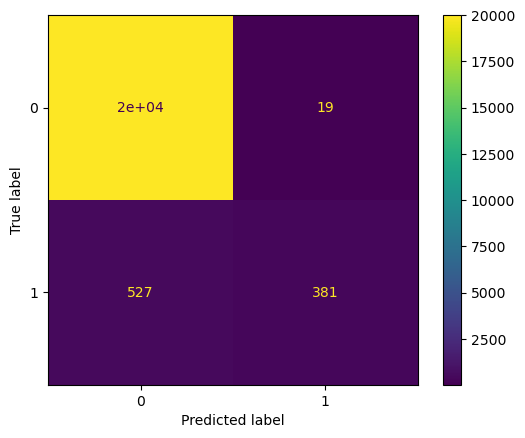

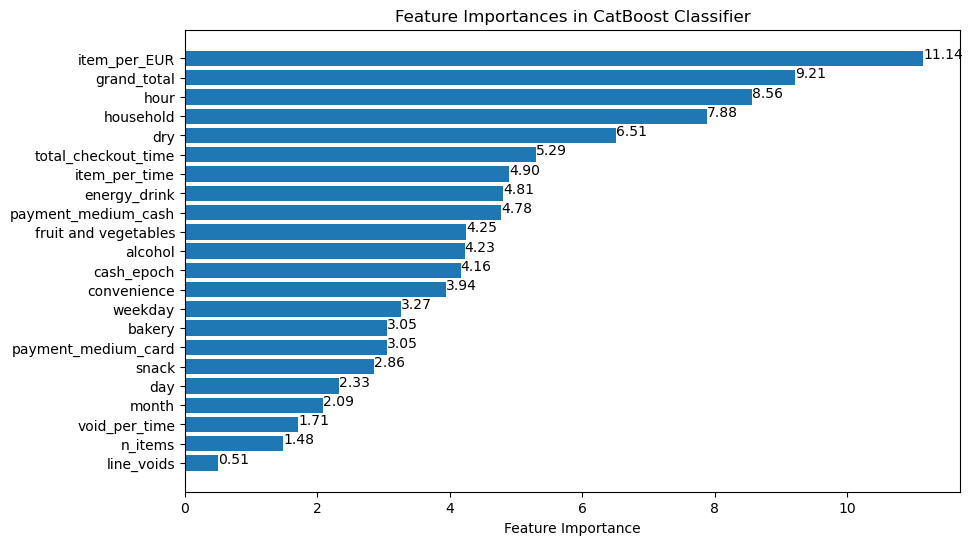

In [31]:
model = CatBoostClassifier(**params,)
train_test(df, model)

Wie erwartet tragen die beiden Attribute nicht zur Verbesserung des Modells bei. Der Tag wird direkt wieder verworfen. Der Monat wird für eine letzte mögliche Optimierung zunächst beibehalten

In [32]:
df = df.drop(["day"], axis=1)

## 10. Weihnachts- und Osterzeit <a class="anchor" id="weihnachten"></a>

Es könnte hilfreich sein, die Weihnachtszeit (November + Dezember) und die Osterzeit (März + April) als Flag zu setzen. Alle weiteren Monate sollen keine Berücksichtigung finden. Der Monat selbst wird somit entfernt.

In [33]:
df["christmas_eastern"] = df["month"].apply(lambda x: 1 if x in [3, 4, 11, 12] else 0)
df = df.drop(["month"], axis=1)

Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [-1095  -675  -780  -855 -1000]
Erreichter mittlerer Gewinn  -881.0
Standardabweichung:  150.51245795614395

Gewinn:  -1190

Konfusionsmatrix:
[[20004    18]
 [  528   380]]


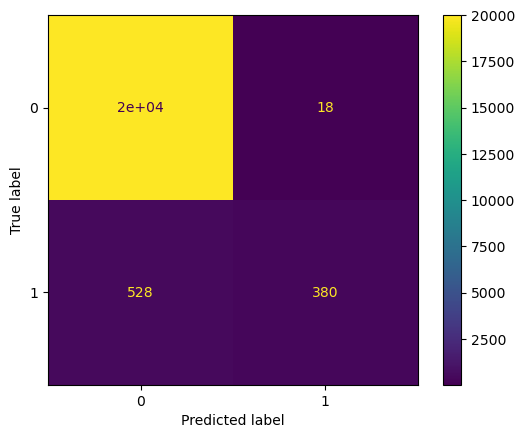

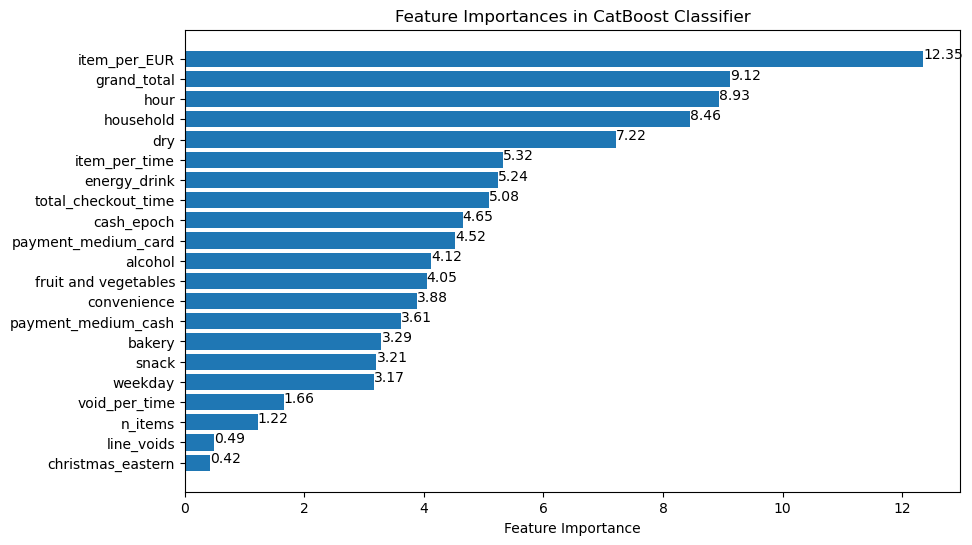

In [34]:
model = CatBoostClassifier(**params,)
train_test(df, model)

Auch dies brachte keine nennenswerte Verbesserung. Ebenfalls wurden lediglich die Monate März und Dezember getestet, aber auch dies blieb erfolglos. Daher wird dieses Attribut wieder entfernt.

In [35]:
df = df.drop(["christmas_eastern"], axis=1)

## 11. Fazit Feature Engineering<a class="anchor" id="fazit"></a>

Das Feature Engineering führte zu mäßig Erfolg. Das Modell konnte im Vergleich zum Datensatz aus der vergangenen Phase verbessert werden. Der in Abschnitt 4 verwendete Datensatz lieferte für das Modell die besten Ergebnisse. Der Datensatz sieht wie folgt aus:

In [36]:
df.head(10)

,grand_total,n_items,total_checkout_time,line_voids,alcohol,fruit and vegetables,snack,dry,convenience,bakery,...,energy_drink,weekday,hour,payment_medium_card,payment_medium_cash,label,cash_epoch,item_per_time,item_per_EUR,void_per_time
0,63.31,24,324,1,1,5,1,11,3,3,...,0,0,8,1,0,0,0,0.074074,0.379087,0.041667
1,29.59,11,92,0,1,2,3,5,0,0,...,0,0,8,1,0,0,0,0.119565,0.371747,0.000000
2,28.70,12,160,0,1,2,1,4,0,4,...,0,0,8,1,0,0,0,0.075000,0.418118,0.000000
3,37.95,8,120,0,0,1,1,3,1,1,...,0,0,8,1,0,0,0,0.066667,0.210804,0.000000
4,5.26,4,79,2,0,1,0,2,0,1,...,0,0,8,1,0,0,0,0.050633,0.760456,0.500000
5,18.13,10,108,0,0,3,2,4,0,1,...,0,0,8,1,0,0,0,0.092593,0.551572,0.000000
6,4.49,2,91,0,0,0,1,0,0,0,...,1,0,9,1,0,0,0,0.021978,0.445434,0.000000
7,45.65,18,217,0,1,6,1,7,0,3,...,0,0,9,1,0,0,0,0.082949,0.394304,0.000000
8,0.79,1,39,0,0,1,0,0,0,0,...,0,0,9,1,0,0,0,0.025641,1.265823,0.000000
9,13.11,11,95,0,0,4,2,4,0,1,...,0,0,9,1,0,0,0,0.115789,0.839054,0.000000


## 12. Hyperparameter Tuning <a class="anchor" id="gitter"></a>

Parameter, über die ein Algorithmus nicht optimiert, sondern die im Vorfeld festgelegt werden, nennt man Hyperparameter. Die optimalen Werte für diese Parameter gilt es für den jeweiligen Datensatz zu finden. Mit Hilfe der sci-kit learn Funktion Gridsearch können verschiedene Parameterkombination ausprobiert und die beste ausgegeben werden. Wir werden hier nur eine kleine Auswahl der Paramtersuche zeigen, da die Rechenzeit entsprechend hoch ist. Der entscheidende Paramter für CatBoost ist 'learning_rate', dessen Optimum bei 0.03 gefunden wird und eine deutliche Verbesserung der Ergebnisse nach sich zieht.

In [45]:
# Gittersuche für CatBoost
param_grid = {
    'learning_rate': [0.1, 0.05, 0.03],
    'depth':[6, 9],
    'boosting_type': ['Ordered', 'Plain'],
   
}

model = CatBoostClassifier(objective = 'Logloss', random_state = RANDOM_STATE, loss_function = "AUC", verbose = False)
gittersuche(model, param_grid, df.drop(["label"], axis=1), df["label"])


Beste Parameter:  {'boosting_type': 'Plain', 'depth': 6, 'learning_rate': 0.03}
Bester Score:  -1044.0


In [37]:
params = {
    'learning_rate': 0.03,
    'objective': 'Logloss',
    'random_state': RANDOM_STATE,
    'depth' : 6,
    'boosting_type':'Ordered',
    "loss_function": "AUC",
    'verbose':False
}

Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [-970 -520 -970 -715 -870]
Erreichter mittlerer Gewinn  -809.0
Standardabweichung:  172.0

Gewinn:  -1235

Konfusionsmatrix:
[[20011    11]
 [  550   358]]


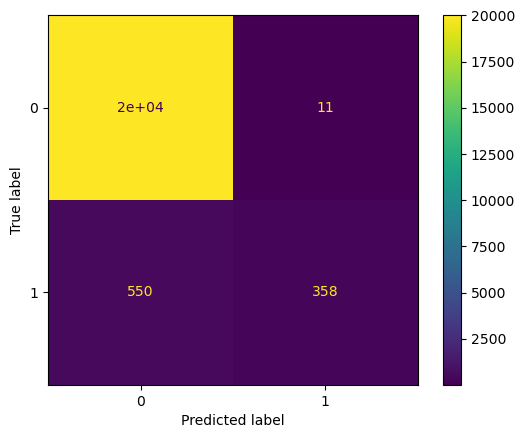

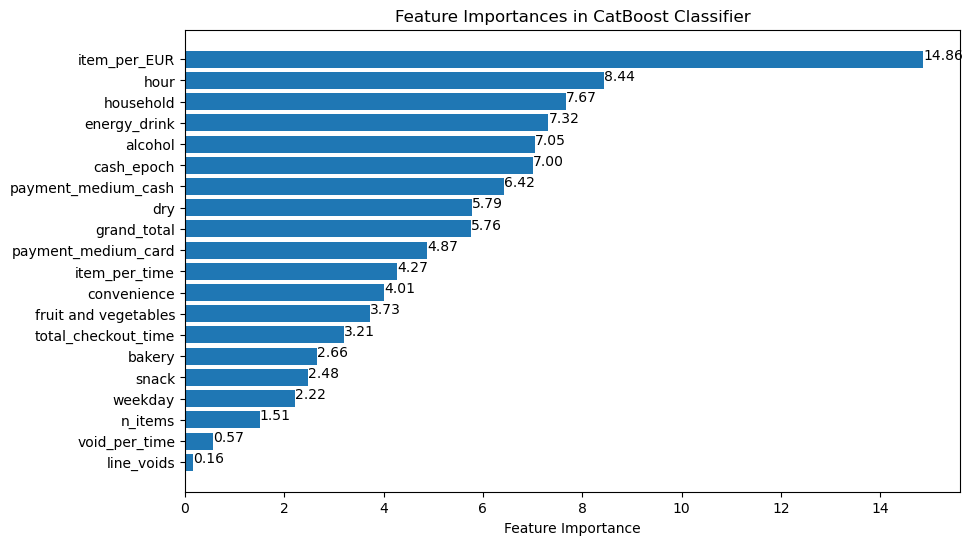

In [38]:
model = CatBoostClassifier(**params)
train_test(df, model)

Diese Parametereinstellung verbessert das Modell und sorgt dafür, dass dieses verallgemeinert. Zwar ist das Ergebnis auf den 20% der Testdaten etwas schlechter geworden, allerdings ist im Durchschnitt der Kreuzvalidierung eine deutliche Verbesserung zu erkennen.

## 13. Umgang mit unbalancierten Daten <a class="anchor" id="void"></a>

Der Datensatz ist unbalanciert ist, das heißt die Klasse label = 0 ist ca. 22-mal größer als die Klasse label = 1. Bei CatBoost, wie bei vielen Algorithmen, die auf Entscheidungsbäumen aufbauen, kann dies beim Ziehen der Datenobjekte auf aulgorithmischen Level berücksichtigt werden. Dies hat den großen Vorteil, das man nicht die Daten selbst verändern muss, wie man es mit verschiedenen Resampling-Methoden (z.B. SMOTE, ADASYN oder ENN) macht. Wir nutzen den Parameter "class_weight", um auszuprobieren, ob sich Ergebnisse durch Berücksichtigung der Unausgeglichenheit des Datensatzes weiter verbessern lassen.

Ergebnisse der Kreuzvalidierung:

Erreichte Gewinne:  [-73115 -72630 -69800 -68600 -68265]
Erreichter mittlerer Gewinn  -70482.0
Standardabweichung:  2023.300768546288

Gewinn:  -88485

Konfusionsmatrix:
[[16381  3641]
 [  200   708]]


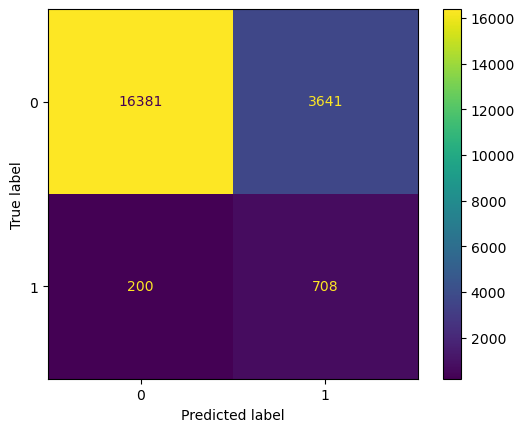

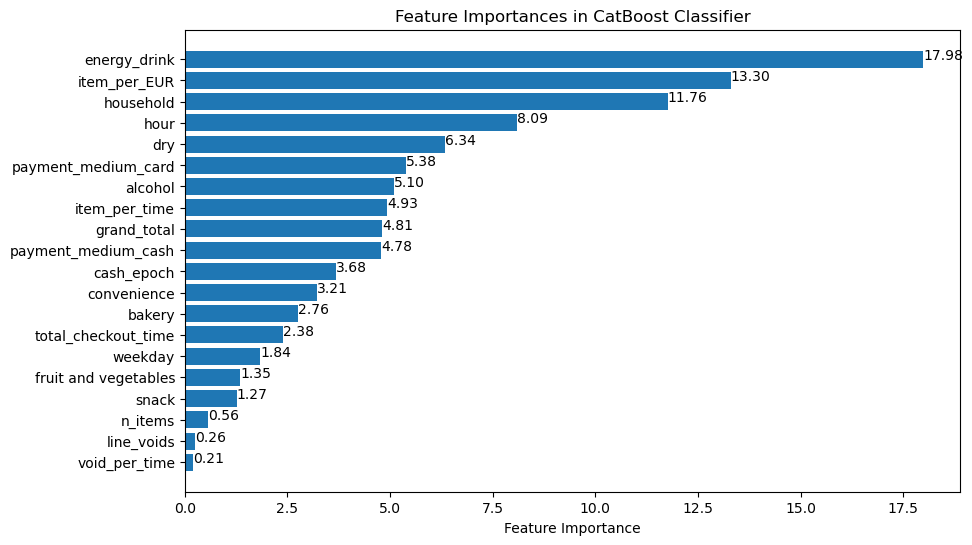

In [39]:
class_weight = df[df['label']==0].shape[0] / df[df['label']==1].shape[0] # Verhältnis der Größe der beiden Klassen
model = CatBoostClassifier(learning_rate = 0.03, objective = 'Logloss', 
                           random_state = RANDOM_STATE, loss_function = "AUC", 
                           depth = 6, boosting_type='Ordered', class_weights=[1/class_weight, 1] ,verbose = False)
train_test(df, model)

Die Berücksichtigung der Unausgeglichheit des Datensatzes mittels dem Parameter "class_weights" bringt keine weitere Verbesserung.

## 14. Vorhersage der Testdaten für 2019 <a class="anchor" id="abgabe"></a>

Abschließend wird das trainierte Modell auf dem zur Verfügung gestellten Testdaten aus 2019 angewendet, um Vorhersagen für den nicht gelabelten Datensatz zu treffen. Die Ergebnisse werden als CSV-Datei gespeichert.

In [40]:
#Alle o.g. Transformationsschritte zusammengefasst, die zum finalen Datensatz des Modells führen
def transform_test(df):
    df["cash_epoch"] = 1
    df["item_per_time"] = df["n_items"] / df["total_checkout_time"]
    df["item_per_EUR"] = df["n_items"] / df["grand_total"]
    df["void_per_time"] = df["line_voids"] / df["n_items"]
    df = df.drop(['most_freq_product_alcohol', 'most_freq_product_bakery',
       'most_freq_product_convenience', 'most_freq_product_dry',
       'most_freq_product_energy_drink',
       'most_freq_product_fruit and vegetables', 'most_freq_product_household',
       'most_freq_product_snack', 'cash_desk_id'], axis=1)
    return df

In [41]:
#Trainiere das Modell auf den gesamten Trainingsdaten
model = CatBoostClassifier(**params)
model.fit(df.drop(["label"], axis=1), df["label"])

In [42]:
#Einlesen des transformierten Test-Datensatzes aus 2019
df_test = pd.read_csv("final_df_test.csv", sep=",", index_col=0)

In [43]:
df_test = transform_test(df_test)

In [44]:
df_test.head(10)

,grand_total,n_items,total_checkout_time,line_voids,alcohol,fruit and vegetables,snack,dry,convenience,bakery,household,energy_drink,weekday,hour,payment_medium_card,payment_medium_cash,cash_epoch,item_per_time,item_per_EUR,void_per_time
0,5.78,3,324,0,0,2,0,1,0,0,0,0,2,8,0,1,1,0.009259,0.519031,0.000000
1,73.89,27,92,4,2,6,2,15,1,0,1,0,2,8,1,0,1,0.293478,0.365408,0.148148
2,7.38,3,160,0,0,0,1,0,0,0,0,2,2,9,1,0,1,0.018750,0.406504,0.000000
3,144.06,58,120,9,1,14,6,24,0,11,2,0,2,9,0,1,1,0.483333,0.402610,0.155172
4,10.78,4,79,0,0,0,1,0,0,0,0,3,2,9,1,0,1,0.050633,0.371058,0.000000
5,1.99,1,108,0,0,0,1,0,0,0,0,0,2,9,0,1,1,0.009259,0.502513,0.000000
6,5.79,2,91,0,0,0,0,0,0,0,0,2,2,9,1,0,1,0.021978,0.345423,0.000000
7,22.22,8,217,0,0,0,5,0,0,0,0,3,2,9,1,0,1,0.036866,0.360036,0.000000
8,5.79,2,39,1,0,0,0,0,0,1,0,1,2,9,1,0,1,0.051282,0.345423,0.500000
9,5.38,2,95,0,0,0,1,0,0,0,0,1,2,9,0,1,1,0.021053,0.371747,0.000000


In [45]:
res = model.predict(df_test)
res

array([1, 0, 0, ..., 0, 0, 0])

In [46]:
# Dateiname für die CSV-Datei
dateiname = "final_result.csv"

# Speichern des NumPy-Arrays als CSV
np.savetxt(dateiname, res, delimiter=",", fmt="%d", encoding="utf-8", header="label_pred")

In [47]:
np.count_nonzero(res == 1)

5082